In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import IPython
import time
import subprocess
import ffmpeg
from datetime import timedelta as td
from pyAudioAnalysis import audioSegmentation as aS
from IPython.display import Audio
from scipy.signal import butter, lfilter
import uuid
import wave, struct, math, random
import scipy.io.wavfile as scipywav
import argparse
import io
from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../kota-108-credential.json"

In [2]:
def convert_audio(old_audio, new_audio):
    # -hide_banner, -loglevel panic digunakan untuk menghilangkan keluaran ketika process convert
    # -y digunakan untuk auto replace audio ketika convert dengan nama yang sama
    commands = ['ffmpeg', '-hide_banner', '-loglevel', 'panic', '-y', '-i', old_audio, new_audio]
    try:
        subprocess.check_call(commands)
    except subprocess.CalledProcessError as error:
        print(error)
        return False
    
    return True

In [3]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    
    return y

In [4]:
def _stft(y, n_fft, hop_length, win_length):
    
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

def _istft(y, hop_length, win_length):
    
    return librosa.istft(y, hop_length, win_length)

def _amp_to_db(x):
    
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)

def _db_to_amp(x,):
    
    return librosa.core.db_to_amplitude(x,ref=1.0)

def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20,4))
    cax = ax.matshow(signal, origin = 'lower', aspect='auto', cmap=plt.cm.seismic, vmin=-1*np.max(np.abs(signal)), vmax=np.max(np.abs(signal)))
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
def plot_statistics_and_filter(mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter):
    fig, ax = plt.subplots(ncols=2, figsize=(20,4))
    plt_mean, = ax[0].plot(mean_freq_noise, label='Mean power of noise')
    plt_std, = ax[0].plot(std_freq_noise, label='Std. power of noise')
    plt_std, = ax[0].plot(noise_thresh, label='Noise threshold (by frequency)')
    ax[0].set_title('Threshold for mask')
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin = 'lower')
    fig.colorbar(cax)
    ax[1].set_title('Filter for smoothing Mask')
    plt.show()
    
def removeNoise(audio_clip, noise_clip, n_grad_freq=2, n_grad_time=4, n_fft=4096, win_length=2048, hop_length=512, n_std_thresh=1.5, prop_decrease=1.0, verbose=False, visual=False):
    """
    Menghilangkan noise dari audio berdasarkan clip audio yang memiliki noisi

    Parameter
    ----------
    n_grad_freq : int
        banyaknya channel frekuensi yang akan di lakukan smoothing dengan mask
    n_grad_time :
        banyaknya channel time yang akan dilakukan smoothing dengan mask
    n_fft : int
        nilai frame audio pada kolom STFT
    win_length : int
        masing-masing frame audio windowed dengan 'window()'. Window akan menjadi panjang 'win_length' dan ditambahkan dengan nilai 0 untuk menyamai 'n_fft'
    hop_length : int
        Jumlah frame audio diantara kolom STFT
    n_std_thresh : float
        berapa banyak standar deviasi lebih keras dari nilai rata-rate desibel dari noise (pada setiap level frekuensi) yang dianggap sebagai sinyal
    prop_decrease : float
        sejauh mana noise dikurangi (1 = all. 0 = none)
    visual : bool
        menampilkan plot dari algoritma
    """
    
    if verbose: start = time.time()
        
    # STFT pada noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length) 
    noise_stft_db = _amp_to_db(np.abs(noise_stft))# convert ke dB
    
    # Menghitung statistik pada noise
    mean_freq_noise = np.mean(noise_stft_db, axis =1)
    std_freq_noise = np.std(noise_stft_db, axis =1)
    noise_thresh = mean_freq_noise+std_freq_noise*n_std_thresh
    
    if verbose: print('STFT on noise:', td(seconds=time.time()-start)); start = time.time()
        
    # STFT pada sinyal audio
    if verbose: start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    
    if verbose: print('STFT on signal:',td(seconds=time.time()-start)); start = time.time()
        
    # Menghitung nilai masing pada desibel
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    
    # Membuat filter smoothing untuk masking pada waktu dan frekuensi
    smoothing_filter = np.outer(np.concatenate([np.linspace(0,1,n_grad_freq+1,endpoint=False),np.linspace(1,0,n_grad_freq+2)])[1:-1], 
                       np.concatenate([np.linspace(0,1,n_grad_time+1,endpoint=False),np.linspace(1,0,n_grad_time+2)])[1:-1])
    smoothing_filter = smoothing_filter/np.sum(smoothing_filter)
    
    # Menghitung threshold pada setiap frekuensi/time bin
    db_thresh = np.repeat(np.reshape(noise_thresh, [1,len(mean_freq_noise)]), np.shape(sig_stft_db)[1], axis = 0).T
    
    # Mask apabila sinyal diatas nilai threshold
    sig_mask = sig_stft_db<db_thresh
    
    if verbose: print('Masking:', td(seconds=time.time()-start)); start = time.time()
        
    # Convolce mask dengan smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter,  mode='same')
    sig_mask = sig_mask*prop_decrease
    
    if verbose: print('Mask convolution:', td(seconds=time.time()-start)); start = time.time()
        
    # Mask sinyal audio
    sig_stft_db_masked = sig_stft_db *(1-sig_mask) + np.ones(np.shape(mask_gain_dB))*mask_gain_dB*sig_mask # mask real
    sig_imag_masked = np.imag(sig_stft)*(1-sig_mask)
    sig_stft_amp = ((_db_to_amp(sig_stft_db_masked)*np.sign(sig_stft))+(1j * sig_imag_masked))
    
    if verbose: print('Mask application:', td(seconds=time.time()-start)); start = time.time()
        
    # Mengembalikan sinyal audio kedalam bentuk time series
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(np.abs(_stft(recovered_signal, n_fft, hop_length, win_length)))
    
    if verbose: print('Signal recovery:', td(seconds=time.time()-start));
    if visual: plot_spectrogram(noise_stft_db, title='Noise')
    if visual: plot_statistics_and_filter(mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter)
    if visual: plot_spectrogram(sig_stft_db, title='Signal')
    if visual: plot_spectrogram(sig_mask, title='Mask applied')
    if visual: plot_spectrogram(sig_stft_db_masked, title='Masked signal')
    if visual: plot_spectrogram(recovered_spec, title='Recovered spectrogram')
    
    return recovered_signal

In [5]:
def getNoise(audio, timeStart, timeEnd, sr):
    """
    Deskripsi: 
        Function untuk mengambil noise dari audio.

    Parameter:
        Audio(Array):

        timeStart(Float):

        timeEnd(Float):

        sr(int):

    Return:
        Noise(Array):

    """
    noise = audio[int(sr*timeStart):int(sr*timeEnd)]
    
    return noise

In [6]:
audio_path = "../uploaded_file/Sampel6.wav"

In [7]:
# Test band pass
convert_audio(audio_path, "../uploaded_file/coverted.wav")

True

In [9]:
# Input audio, load audio
try:
    audio, sr = librosa.load(audio_path, sr=None)

    lowcut = 85
    highcut = 255

    # Melakukan Proses Bandpass Filter
    filtered_audio = butter_bandpass_filter(audio, lowcut, highcut, sr)

    # Pengambilan clip noise dari audio
    noise_audio = getNoise(filtered_audio, 12.204, 18.538, sr)
    print(noise_audio)

    # Proses noise reduction
    reduced_audio = removeNoise(filtered_audio, noise_audio)
except ValueError as err:
    print(err)

[-55.83645  -54.220963 -52.100777 ... -76.14497  -76.14497  -76.14497 ] -63.351448


/Users/nmuntaaza/Desktop/App/Web/audio_transcribe/venv/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(26, 35 - 1) = 26 components.
  ChangedBehaviorWarning)
/Users/nmuntaaza/Desktop/App/Web/audio_transcribe/venv/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


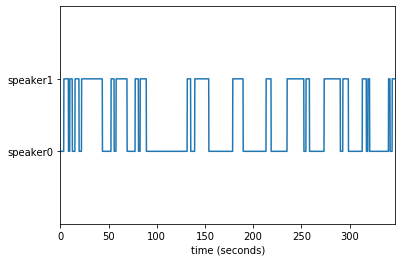

In [10]:
diarization = aS.speakerDiarization(reduced_audio, sr, 2, plot_res=True)

In [11]:
"""
Mengambil Label pada 0.2 detik pertama
"""
first = diarization[0]
print("Speaker: {}, len : {}".format(diarization,len(diarization)))
"""
time: Variabel untuk menunjukan panjang/lama satu bagian pembicaraan
first_time: Variabel untuk menunjukan kapan perubahan speaker terjadi
"""
time = 0.0
first_time = 0.0
"""
nol: Variabel untuk menampung audio speaker 1
one: Variabel untuk menampung audio speaker 2
"""
nol = []
one = []

"Melakukan Looping selama ada data label didalam variabel diarization"
for index, i in enumerate(diarization):
    "Jika Label pada i belum mengalami perubahan label maka tambahkan panjang pembicaraan label i sepanjang 0.2 detik"
    if i == first and index < (len(diarization))-1:
        time += 0.2
    else:
        "Audio_Clip: Variabel untuk menampung potongan audio dengan start time (first_time) dan end time (time)"
        audio_clip = audio[int(sr*first_time):int(sr*time)]
        
        "Jika Speaker yang berbicara speaker 1 (0)"
        if int(i) < 1:
            #Jika Label Speaker 0
            "Memasukan Potongan Audio kedalam Array Nol dengan waktu yang sama"
            nol[int(sr*first_time):int(sr*time)] = audio_clip
            "Memasukan nilai 0 pada array one dengan waktu yang sama"
            one[int(sr*first_time):int(sr*time)] = [0 for k in range(int(sr*time) - int(sr*first_time))]
            "Jika Speaker yang berbicara speaker 2 (1)"
        else:
            #Jika Label Speaker 1
            "Memasukan Potongan Audio kedalam Array one dengan waktu yang sama"
            one[int(sr*first_time):int(sr*time)] = audio_clip
            "Memasukan nilai 0 pada array nol dengan waktu yang sama"
            nol[int(sr*first_time):int(sr*time)] = [0 for k in range(int(sr*time) - int(sr*first_time))]
            
        print("Speaker: {}".format(first))
        print("Timestamp: {}-{}".format(first_time, time))
        print("")
        "Mengubah first_time menjadi time"
        first_time = time
        "Mengubah nilai label first menjadi label selanjutnya pada array diarization"
        first = i
        "memasukan label speaker pembicara terakhir"
        last_speaker = i

#Proses Pemisahan Label Terakhir
audio_clip = audio[int(sr*first_time):int(sr*time)]
if int(last_speaker) < 1:
    nol[int(sr*first_time):int(sr*time)] = audio_clip
    one[int(sr*first_time):int(sr*time)] = [0 for k in range(int(sr*time) - int(sr*first_time))]
else:
    one[int(sr*first_time):int(sr*time)] = audio_clip
    nol[int(sr*first_time):int(sr*time)] = [0 for k in range(int(sr*time) - int(sr*first_time))]

Speaker: [0. 0. 0. ... 1. 1. 1.], len : 1737
Speaker: 0.0
Timestamp: 0.0-3.600000000000001

Speaker: 1.0
Timestamp: 3.600000000000001-8.200000000000003

Speaker: 0.0
Timestamp: 8.200000000000003-9.399999999999999

Speaker: 1.0
Timestamp: 9.399999999999999-11.79999999999999

Speaker: 0.0
Timestamp: 11.79999999999999-14.39999999999998

Speaker: 1.0
Timestamp: 14.39999999999998-18.399999999999967

Speaker: 0.0
Timestamp: 18.399999999999967-20.799999999999958

Speaker: 1.0
Timestamp: 20.799999999999958-42.20000000000006

Speaker: 0.0
Timestamp: 42.20000000000006-51.000000000000185

Speaker: 1.0
Timestamp: 51.000000000000185-54.00000000000023

Speaker: 0.0
Timestamp: 54.00000000000023-55.80000000000025

Speaker: 1.0
Timestamp: 55.80000000000025-67.00000000000041

Speaker: 0.0
Timestamp: 67.00000000000041-75.20000000000053

Speaker: 1.0
Timestamp: 75.20000000000053-78.40000000000057

Speaker: 0.0
Timestamp: 78.40000000000057-80.0000000000006

Speaker: 1.0
Timestamp: 80.0000000000006-86.20000

## Hasil Audio Speaker 1

In [20]:
IPython.display.Audio(data=nol, rate=sr)

## Hasil Audio Speaker 2

In [21]:
IPython.display.Audio(data=one, rate=sr)

## Proses Speech to Text

In [22]:
def floatToPcm (audio):
    """
        Deskripsi: Function untuk merubah isi data array audio dari bentuk float kedalam bentuk int16
        
        Parameter: 
            audio: Numpy array
        
        Output:
            audio: Numpy array
    """
    floatLimit = 1.414
    intLimit = 32767
    
    with np.nditer(audio, op_flags=['readwrite']) as x:
        for i in x:
            i /= floatLimit
            i *= intLimit
            
    audio_pcm = audio.astype(np.int16)
    
    return audio_pcm

def writetowav(audio,sr):
    """
        Deskripsi: Function untuk menyimpan data array audio kedalam file wav
        
        Parameter: 
            audio: Numpy array
            sr: integer
            
        Output:
            tempid: String
    """
    tempid = uuid.uuid4().hex[:10].upper()
    
    npaudio = np.array(audio)
    
    audio_pcm = floatToPcm(audio=npaudio)
    scipywav.write("../wavtemp/{}.wav".format(tempid),sr,audio_pcm)
    
    return tempid

def readbinaudio(path):
    """
        Deskripsi: Function untuk membaca file .wav dalam bentuk binary
        
        Parameter: 
            path: String
            
        Output:
            content: String
    """
    with io.open(path, 'rb') as audio_file:
        content = audio_file.read()
    return content

def removebinaudio(path):
    """
        Deskripsi: Function untuk menghapus file
        
        Parameter: 
            path: String
            
        Output:
            
    """
    if os.path.exists(path):
        os.remove(path)
        
def transcribeaudio(path):
    """
        Deskripsi: Function untuk melakukan transkripsi audio
        
        Parameter: 
            path: String
            
        Output:
            response: array
    """
    content = readbinaudio(path)
    client = speech.SpeechClient()
    audio = types.RecognitionAudio(content=content)

    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        language_code='id')

    response = client.recognize(config, audio)

    for result in response.results:
        print('Transcript: {}'.format(result.alternatives[0].transcript))

In [23]:
tempone = writetowav(nol,sr)
temptwo = writetowav(one,sr)

pathone = "../wavtemp/{}.wav".format(tempone)
pathtwo = "../wavtemp/{}.wav".format(temptwo)

print(pathone)
print(pathtwo)

../wavtemp/04AE842F94.wav
../wavtemp/83B7004CD0.wav


Hasil Transkrip Audio Speaker 1

In [27]:
# Transkripsi Speaker 1
transcribeaudio(pathone)

KeyboardInterrupt: 

Hasil Transkrip Audio Speaker 2

In [ ]:
# Transkripsi Speaker 2
transcribeaudio(pathtwo)